Небольшой отчет о проделанной работе и трудностях, с которыми я столкнулся во время выполнения тестового задания.

Задача: Решить задачу бинарной классификации и затем посчитать метрику NDCG

Модели для решения:\
1) KNN\
2) LogisticRegression\
3) XGBoost\
4) CatBoost\
5) SVM

KNN - не подходит из-за большого количества фичей и простоты. В многомерном пространстве расстояния ведут себя не очень стандартно (проклятие размерности).

Все остальные методы я решил попробовать и выбрать наиболее подходящий.

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ndcg_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, log_loss
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

In [5]:
!pip install catboost

Подготавливаем данные.\
'target', 'search_id' - нужно удалить из датасета\
'feature_0', 'feature_73', 'feature_74', 'feature_75' - признаки с константными значениями, значит можем их сразу удалить из датасета и тестовой выборки

In [137]:
train_data = pd.read_csv('train_df.csv')
target = train_data['target']
data = train_data.drop(columns=['target', 'search_id', 'feature_0', 'feature_73', 'feature_74', 'feature_75'])
train_data.shape

(15081, 81)

Получаем X_train и y_train. Дальше видим, что у нас высокий дисбаланс классов. Отношение точек первого класса к нулевому равно, примерно, 0.02.\
Варианты решений:\
1) Уменьшить количество точек нулевого класса
```
rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(X_train, y_train)
```
2) Увеличить количество точек первого класса
```
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
```
3) Задать специальные веса для классов в самих моделях

Предобработка данных:\
Можно сгенерировать новые фичи:
```
poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
```

Можно сжать размерность:
```
pca = PCA(n_components=20)
X_train = pca.fit_transform(X_train)
```

Можно нормализовать данные
```
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
```

Можно посмотреть на ковариацию с таргетом. (Посмотрел, все признаки имеют слабую ковариацию, непонятно - какие признаки стоит выкинуть, а какие нет, поэтому ничего не выкидываем.

In [138]:
X_train, y_train = data, target.values
# rus = RandomUnderSampler()
# X_train, y_train = rus.fit_resample(X_train, y_train)
# poly = PolynomialFeatures(degree=2)
# X_train = poly.fit_transform(X_train)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)
# pca = PCA(n_components=20)
# X_train = pca.fit_transform(X_train)

# X_train.shape

Пробуем сжать признаковое пространство до размерности 2 и посмотреть на то, как распределены точки на графике. К сожалению, ничего хорошо из графика получить не удалось, классы максимально перемешаны

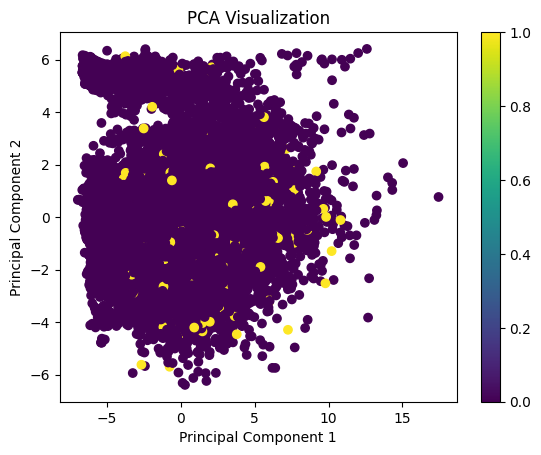

In [8]:
pca = PCA(n_components=2)
n_data = StandardScaler().fit_transform(X_train)
reduced_data = pca.fit_transform(n_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.colorbar()
plt.show()

Так как мы хотим считать метрику NDCG, то нам нужно как-то понимать, хорошо ли мы ранжируем или нет. y_pred веротяность принадлежания к классу 1, y_true - реальное значение. Для максимизирования метрики NDCG, нам надо, чтобы наиболее релевантные обьекты находились спереди, поэтому мы сортируем индексы y_pred по уменьшению вероятности и дальше выводим новые y_true и y_pred. В итоге в консоли мы будем видеть нижнюю и верхнюю строчку, на верхней строчке будет находиться реальный класс точки, а на нижней вероятность принадлежать к классу 1. Тем самым мы хотим, чтобы большим вероятностям соответствовали еденицу. Тем самым, если в начале верхней строки мы видим еденицы, а в конце нули, то наш классификатор хорошо работает. Именно на такую "метрику" мы будем смотреть, во время оптимизирования модели. Функция print_y - выводит эти две строчки.

In [9]:
def print_y(y_pred, y_true):
  sorted_indices = np.argsort(y_pred)[::-1]
  y_true = y_true[sorted_indices]
  y_pred = y_pred[sorted_indices]
  for i in y_true:
    print(i, end=" ")
  print()
  for i in y_pred:
    print(i, end=" ")

In [139]:
test_data = pd.read_csv('test_df.csv')
y_test = test_data['target'].values
X_test = test_data.drop(columns=['target', 'search_id', 'feature_0', 'feature_73', 'feature_74', 'feature_75'])

# Градиентный бустинг - CatBoost.
Попробуем решить задачу с помощью CatBoost, чтобы модель не переобучалась, передадим в модель валидационный датасет и будем пробовать подбирать различные гиперпараметры (в том числе дополнительная регуляризация) для лучшего результата.

In [16]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, target.values, test_size=0.2, random_state=42)

model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.001,
                           depth=6,
                           loss_function='Logloss',
                           scale_pos_weight=50,
                           random_seed=42)

eval_set = [(X_val, y_val)]

model.fit(X_train, y_train, eval_set=eval_set, use_best_model=True, verbose=500)

0:	learn: 0.6927785	test: 0.6930452	best: 0.6930452 (0)	total: 17.1ms	remaining: 2m 50s
500:	learn: 0.5420216	test: 0.7095294	best: 0.6922595 (118)	total: 8.34s	remaining: 2m 38s
1000:	learn: 0.4384718	test: 0.7479855	best: 0.6922595 (118)	total: 15.2s	remaining: 2m 16s
1500:	learn: 0.3633578	test: 0.7936460	best: 0.6922595 (118)	total: 23.3s	remaining: 2m 11s
2000:	learn: 0.3054559	test: 0.8470554	best: 0.6922595 (118)	total: 31.5s	remaining: 2m 5s
2500:	learn: 0.2605954	test: 0.9040848	best: 0.6922595 (118)	total: 38.4s	remaining: 1m 55s
3000:	learn: 0.2244438	test: 0.9544324	best: 0.6922595 (118)	total: 46.5s	remaining: 1m 48s
3500:	learn: 0.1947017	test: 1.0119908	best: 0.6922595 (118)	total: 53.4s	remaining: 1m 39s
4000:	learn: 0.1694493	test: 1.0708816	best: 0.6922595 (118)	total: 1m 1s	remaining: 1m 32s
4500:	learn: 0.1478487	test: 1.1292744	best: 0.6922595 (118)	total: 1m 9s	remaining: 1m 25s
5000:	learn: 0.1300714	test: 1.1901227	best: 0.6922595 (118)	total: 1m 18s	remaining: 

Посмотрим на результаты:

In [22]:
y_pred = model.predict_proba(X_test)[:, 1]
print_y(y_pred, y_test)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 

Видно, что модель ничему не научилась. Посмотрим, что происходит на тренировочном датасете:

In [25]:
y_pred = model.predict_proba(X_train)[:, 1]
print_y(y_pred, y_train)

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 

Видно, что модель переобучается, так как на тестовом датасете довольно хорошие результаты, хотя я явно передаю валидационный датасет, который должен спасать модель от переобучения.\
Возможные проблемы: категориальные признаки
В текущей модели все признаки числовые, давайте скажем, что если у признака < 9 уникальных значений, то он категориальный. CatBoost хорошо умеет справляться с категориальными признаками.

Ищем индексы категориальных признаков:

In [34]:
cat_features = []
for feature in X_train.columns:
  if len(set(data[feature])) < 9:
    cat_features.append(feature)
print(cat_features)

['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15']


In [35]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, target.values, test_size=0.8, random_state=42)

model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.01,
                           depth=4,
                           l2_leaf_reg=50,
                           loss_function='Logloss',
                           scale_pos_weight=50,
                           random_seed=42)

eval_set = [(X_val, y_val)]

model.fit(X_train, y_train, eval_set=eval_set, use_best_model=True, verbose=500, cat_features=cat_features)

0:	learn: 0.6905063	test: 0.6917127	best: 0.6917127 (0)	total: 42.1ms	remaining: 42.1s
500:	learn: 0.3551873	test: 0.7373781	best: 0.6690602 (91)	total: 8.95s	remaining: 8.91s
999:	learn: 0.2028602	test: 0.9264241	best: 0.6690602 (91)	total: 16.9s	remaining: 0us

bestTest = 0.6690601665
bestIteration = 91

Shrink model to first 92 iterations.


Смотрим на результаты:

In [36]:
y_pred = model.predict_proba(X_test)[:, 1]
print_y(y_pred, y_test)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [37]:
y_pred = model.predict_proba(X_train)[:, 1]
print_y(y_pred, y_train)

1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Видно, что модель переобучается. Подбор различных гиперпараметров не помогает. Тогда попробуем другую модель.

# Логистическая регрессия.
Пробую различные комбинации обработки признаков и различные значения гиперпараметров, но, к сожалению, видно, что модель переобучается и на тестовом датасете выдает очень слабый результат.

In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train = data
y_train = target.values

# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

logreg = LogisticRegression(max_iter=10000, penalty='l2', class_weight='balanced')

logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

Видно, что еденицы встречаются в начале - уже неплохо, но все равно очень слабо.

In [143]:
y_pred = logreg.predict_proba(X_test)[:, 1]

print_y(y_pred, y_test)

1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 

In [144]:
ndcg_score([y_test], [y_pred])

0.5661520714776687

По поводу результатов на тренировочном датасете:\
1) Если добавить SMOTE, то модель переобучается (даже регуляризация не помогает)\
2) Если не добавлять SMOTE, просто сбалансировать веса, то модель недоучивается


In [89]:
y_pred = logreg.predict_proba(X_train)[:, 1]
print_y(y_pred, y_train)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 

# Градиентный бустинг - XGBoost.
Долгий перебор гиперпараметров, функций обработки данных не помогает спастись от проблемы недообучения. Очень слабый результат на тестовом датасете. Попробовал поиск по сетки с оптимизируемой метрикой NDCG от sklearn, но не помогает.

In [133]:
model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=100)

params = {
    'learning_rate': 0.001, 'max_depth': 6, 'n_estimators': 200
}

# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

model.set_params(**params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [135]:
y_proba = model.predict_proba(X_test)[:, 0]
print_y(y_proba, y_test)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 

In [136]:
y_proba = model.predict_proba(X_train)[:, 0]
print_y(y_proba, y_train)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Посмотрим на значение метрики NDCG в случае Random Shuffle таргетов. Видим, что результат получается не хуже, что наши классификаторы - CatBoost, XGBoost и LogReg

In [ ]:
ndcg_score([y_test], [np.random.permutation(y_test)])

0.4127323856625651

Заключение
Я попробовал модели: LogReg, SVM, RandomForest. XGBoost, CatBoost.
RandomForest, SVM я не стал включать в мой отчет, так как он сильно проигрывал градиентному бустингу, аналогично SVM - просто плохо работал. По моим расчетам, наиболее оптимальные модели:\
1) CatBoost - работает лучше всех, но все-равно плохо, основная проблема - переобучение. Пытался ее побороть с помощью гиперпараметра - eval_set и регуляризации, но не помогло.\
2) XGBoost - второе место, работат хуже CatBoost, недообучается.\
3) LogReg - третье место, работает хуже градиентных бустингов, переобучается ли недообучается.\
Во время экспериментов было выяснено, что SMOTE (генерация точек класса 1) немного улучшает качество, остальные методы обработки данных особо не помогали обучению. Иногда SMOTE работал лучше, нежели указание модели специфичных весов - scale_pos_weight.

Итог:\
Максимальный результат метрики NDCG я смог достичь с помощью LogReg: 0.5661520714776687